In [1]:
import os

import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random

import logging
import time
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import load_model
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/boilers_drive/normalized_df.csv'

Mounted at /content/drive


In [3]:
# Specify the file path of your CSV file
#file_path = 'normalized_df.csv'

# the current script directory
# the current working directory
#current_dir = os.getcwd()

# the path to the CSV file in the parent directory
#parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
#file_path = os.path.join(parent_dir, 'normalized_df.csv')

# Read the CSV file
data = pd.read_csv(file_path)

print("Imported data:")
print(data)

Imported data:
                        time    blr_mod_lvl  absorption  insulation  t_r_set  \
0        2022-10-01 00:00:00   0.000000e+00    0.503910    7.457292     15.0   
1        2022-10-01 00:01:00   0.000000e+00    0.503910    7.455208     15.0   
2        2022-10-01 00:02:00   0.000000e+00    0.518558    7.487500     15.0   
3        2022-10-01 00:03:00   0.000000e+00    0.616207    7.426042     15.0   
4        2022-10-01 00:04:00   0.000000e+00    0.699210    7.425000     15.0   
...                      ...            ...         ...         ...      ...   
7602835  2023-04-30 23:55:00  2.871866e-119    0.000000    1.604167     17.0   
7602836  2023-04-30 23:56:00  1.914578e-119    0.000000    1.614583     17.0   
7602837  2023-04-30 23:57:00  1.276385e-119    0.000000    1.572917     17.0   
7602838  2023-04-30 23:58:00  8.509234e-120    0.000000    1.511458     17.0   
7602839  2023-04-30 23:59:00  5.672823e-120    0.000000    1.432203     17.0   

             t_out house

In [4]:
# Identify NaN values
nan_mask = data.isna()
print("NaN mask:\n", nan_mask)

# Get the count of NaN values in each column
nan_count = data.isna().sum()
print("\nNaN count in each column:\n", nan_count)

# List rows with NaN values
rows_with_nan = data[data.isna().any(axis=1)]
nan_houses = rows_with_nan['house_id'].unique()
print("\nRows with NaN values:\n", rows_with_nan)
print("\nHouses with NaN values:\n", nan_houses)

# List columns with NaN values
columns_with_nan = data.columns[data.isna().any()].tolist()
print("\nColumns with NaN values:\n", columns_with_nan)

NaN mask:
           time  blr_mod_lvl  absorption  insulation  t_r_set  t_out  house_id
0        False        False       False       False    False  False     False
1        False        False       False       False    False  False     False
2        False        False       False       False    False  False     False
3        False        False       False       False    False  False     False
4        False        False       False       False    False  False     False
...        ...          ...         ...         ...      ...    ...       ...
7602835  False        False       False       False    False  False     False
7602836  False        False       False       False    False  False     False
7602837  False        False       False       False    False  False     False
7602838  False        False       False       False    False  False     False
7602839  False        False       False       False    False  False     False

[7602840 rows x 7 columns]

NaN count in each column

In [5]:
# Different houses in data
houses = data['house_id'].unique()
print("Different houses in data:")
print(houses)
print("Number of different houses:")
print(len(houses))

Different houses in data:
['home2' 'home9' 'home13' 'home14' 'home34' 'home46' 'home55' 'home67'
 'home86' 'home93' 'home101' 'home106' 'home110' 'home43' 'home63'
 'home53' 'home79' 'home90' 'home95' 'home5' 'home17' 'home47' 'home51'
 'home65' 'home77' 'home89' 'home111' 'home114']
Number of different houses:
28


In [7]:
#house_datasets = {}
#for house in houses:
#    house_datasets[house] = data[data['house_id'] == house]

#print(house_datasets)

**Δημιουργία του encoder decoder transformer**

In [8]:
# positional encoding layer
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)


# positional embedding layer
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Dense(d_model)  # Project input to d_model dimension
    #self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [9]:
# Attention layers
# These are all identical except for how the attention is configured

# base attention layer
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()


# cross attention layer
# (at the center of the Transformer is the cross-attention layer, it connects the encoder and decoder)
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x


# global self attention layer
# (it is responsible for processing the context sequence, and propagating information along its length)
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x


# causal self attention layer
# (it does a similar job as the global self attention layer, for the output sequence)
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x, use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [10]:
# feed forward network
# (the transformer also includes this point-wise feed-forward network in both the encoder and decoder)
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [11]:
# encoder layer
# (the encoder contains a stack of N encoder layers. Where each EncoderLayer contains
#   a GlobalSelfAttention and FeedForward layer)
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [12]:
# The Encoder
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)


  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    # Add dropout.
    x = self.dropout(x)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [13]:
# decoder layer
# (the decoder's stack is slightly more complex, with each DecoderLayer containing
#   a CausalSelfAttention, a CrossAttention, and a FeedForward layer)
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)
    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores
    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [14]:
# The Decoder
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None


  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores
    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [15]:
# The Transformer
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()

    self.input_proj = tf.keras.layers.Dense(d_model)  # Project input to the model dimension

    self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size, dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size, dropout_rate=dropout_rate)

    #self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    self.final_layer = tf.keras.layers.Dense(1)


  def call(self, inputs):  # Expecting only one input
    x = inputs
    #x = self.input_proj(x) # because we get n values for every 1 output value
    context = self.encoder(x)
    x = self.decoder(x, context)
    logits = self.final_layer(x)
    try:
      del logits._keras_mask
    except AttributeError:
      pass
    return logits

**Preparing the data**

In [16]:
# the categories for prediction
final_category = 'blr_mod_lvl'
prediction_categories = ['blr_mod_lvl', 'absorption', 'insulation', 't_r_set', 't_out']


In [25]:
# alternative for data processing

filtered_data = data[['house_id', 'time', 'blr_mod_lvl', 'absorption', 'insulation', 't_r_set', 't_out']].copy()

# scaler for each category
scaler_blr_mod_lvl = MinMaxScaler()
scaler_absorption = MinMaxScaler()
scaler_insulation = MinMaxScaler()
scaler_t_r_set = MinMaxScaler()
scaler_t_out = MinMaxScaler()
# dict for scalers
scalers = {
    "scaler_blr_mod_lvl": scaler_blr_mod_lvl,
    "scaler_absorption": scaler_absorption,
    "scaler_insulation": scaler_insulation,
    "scaler_t_r_set": scaler_t_r_set,
    "scaler_t_out": scaler_t_out
}
# function to get correct scaler
def get_scaler(category_name):
    scaler_name = "scaler_" + category_name
    return scalers.get(scaler_name)

# normalizing categories with scalers (all data from all houses in each category)
for cat in prediction_categories:
    temp = []
    temp = filtered_data[cat].values
    temp = temp.reshape(-1, 1)  # Reshape to a 2D array with a single column
    scaler_temp = get_scaler(cat)
    temp_normalized = scaler_temp.fit_transform(temp)
    new_cat_name = "normalized_" + cat
    filtered_data[new_cat_name] = temp_normalized

# function for reverse scaling of list (depending on category)
def de_scale(cat_list, category):
    scaler = get_scaler(category)
    return scaler.inverse_transform(cat_list)


In [26]:
#print(filtered_data)

In [27]:
# creating sub-lists, each with the data of one day
# the function that gets category data of a house (ordered by date) and separates by day
def separate_into_days(data_list, minutes_per_day=1440):
    # number of days
    num_days = len(data_list) // minutes_per_day
    # the data into a list of sub-lists, each containing one day's data
    separated_data = [
        data_list[i * minutes_per_day:(i + 1) * minutes_per_day]
        for i in range(num_days)
    ]
    return separated_data


# function to "combine" values of categories and separate into sub-lists based on days
def combine_categories(dataset, categories_list):
    # Combine specified categories into lists
    combined_elements = dataset[categories_list].apply(lambda row: row.tolist(), axis=1)
    return combined_elements.tolist()

In [28]:
def prepare_data_2(house_data, input_categories, output_category, minutes_per_day=1440):
    combined_input_data = combine_categories(house_data, input_categories)
    separated_input_data = separate_into_days(combined_input_data, minutes_per_day)
    output = house_data[output_category].values
    separated_output = separate_into_days(output, minutes_per_day)
    # [:, :-1] and [:, 1:] for 2-d arrays
    # [:-1],  and [1:] for 1-d arrays (or lists)
    # all except last day are inputs (for prediction)
    input_data = separated_input_data[:-1]
    # all except first day are the corresponding outputs (from prediction)
    output_data = separated_output[1:]
    return input_data, output_data

In [29]:
# Filter data for the 'absorption' category
#category = 'absorption'
filtered_data = filtered_data[['house_id', 'time', 'normalized_blr_mod_lvl', 'normalized_absorption', 'normalized_insulation', 'normalized_t_r_set', 'normalized_t_out']].copy()
input_chosen_categories = ['normalized_blr_mod_lvl', 'normalized_absorption', 'normalized_t_out']

# We have 1440 minutes per day
minutes_per_day = 1440

# Initialize lists to store input and target pairs
input_data_list, target_data_list = [], []

for house_id in houses:
    #house_data = filtered_data[filtered_data['house_id'] == 'home13']
    house_data = filtered_data[filtered_data['house_id'] == house_id]
    house_data = house_data.sort_values(by='time')
    input_data, target_data = prepare_data_2(house_data, input_chosen_categories, 'normalized_blr_mod_lvl')
    input_data_list.append(input_data)
    target_data_list.append(target_data)

# Combine all houses' data
input_data = np.concatenate(input_data_list, axis=0)
target_data = np.concatenate(target_data_list, axis=0)


In [30]:
# !! Data Normalization !! Doing it anohter way !!
# Data normalization for input and target data
#scaler_input = MinMaxScaler()
#scaler_target = MinMaxScaler()

# Normalize input
#input_data = np.array(input_data)
#input_data_normalized = scaler_input.fit_transform(input_data)

# Normalize target
#target_data = np.array(target_data)
#target_data_normalized = scaler_target.fit_transform(target_data)

# !! Notes for later!!!
# for predictions: normalize-predict-denormalize
# Normalize new data
# Predict
#  predictions_normalized = model.predict(new_input_data_normalized)
# Denormalize predictions
#  predictions = scaler_target.inverse_transform(predictions_normalized)

In [38]:
# Properly split datasets for train, validation, test
# from original data: 80%-20% split, where 20% is for test. from remaining 80% : 80%-20% split, for train and validation

batch_size = 8 # Reduce the batch size, in case it helps !

# Split the data into train+val and test sets
input_train_val, input_test, target_train_val, target_test = train_test_split(input_data, target_data, test_size=0.2, random_state=42)

# Further split train+val into train and val sets
input_train, input_val, target_train, target_val = train_test_split(input_train_val, target_train_val, test_size=0.2, random_state=42)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((input_train, target_train))
train_dataset = train_dataset.cache().shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((input_val, target_val))
val_dataset = val_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((input_test, target_test))
test_dataset = test_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


In [39]:
print(input_train.shape)
print(target_train.shape)
print(input_val.shape)
print(target_val.shape)
print(input_test.shape)
print(target_test.shape)

(3357, 1440, 3)
(3357, 1440)
(840, 1440, 3)
(840, 1440)
(1050, 1440, 3)
(1050, 1440)


In [40]:
# Define the Transformer model
#model = Transformer(num_layers=4, d_model=128, num_heads=8, dff=512, input_vocab_size=minutes_per_day,
#                    target_vocab_size=minutes_per_day, dropout_rate=0.1) # minutes_per_day = 1440
model = Transformer(num_layers=4, d_model=64, num_heads=4, dff=256, input_vocab_size=minutes_per_day,
                    target_vocab_size=minutes_per_day, dropout_rate=0.1) # minutes_per_day = 1440

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [41]:
def train_model(model, train_dataset, val_dataset, model_name, save_path='/content/drive/Othercomputers/My_Laptop/code/models'):
  # Define the EarlyStopping callback
  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',  # Metric to monitor
      patience=5,          # Number of epochs with no improvement after which training will be stopped
      verbose=1,           # Verbosity mode
      restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
  )

  # Train the model with the EarlyStopping callback
  history = model.fit(
      train_dataset,       # Training dataset
      epochs=20,          # Number of epochs
      validation_data=val_dataset,  # Validation dataset
      callbacks=[early_stopping]  # List of callbacks to apply during training
  )
  # change epochs, patience , etc !!! (e.g. epochs=10, patience=3  or  epochs=20, patience=5)

  # save trained model
  model.save(save_path + model_name, save_format='tf')
  # save history of training
  with open(save_path + model_name + '_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  return history, model

In [42]:
history, model = train_model(model, train_dataset, val_dataset, 'transformer_1')

Epoch 1/20
420/420 [==============================] - 339s 732ms/step - loss: 0.1767 - mean_absolute_error: 0.1551 - val_loss: 0.0096 - val_mean_absolute_error: 0.0360
Epoch 2/20
420/420 [==============================] - 306s 729ms/step - loss: 0.0121 - mean_absolute_error: 0.0588 - val_loss: 0.0123 - val_mean_absolute_error: 0.0532
Epoch 3/20
420/420 [==============================] - 305s 727ms/step - loss: 0.0110 - mean_absolute_error: 0.0531 - val_loss: 0.0090 - val_mean_absolute_error: 0.0431
Epoch 4/20
420/420 [==============================] - 305s 727ms/step - loss: 0.0103 - mean_absolute_error: 0.0503 - val_loss: 0.0089 - val_mean_absolute_error: 0.0412
Epoch 5/20
420/420 [==============================] - 305s 727ms/step - loss: 0.0101 - mean_absolute_error: 0.0493 - val_loss: 0.0093 - val_mean_absolute_error: 0.0573
Epoch 6/20
420/420 [==============================] - 305s 727ms/step - loss: 0.0102 - mean_absolute_error: 0.0497 - val_loss: 0.0088 - val_mean_absolute_error:

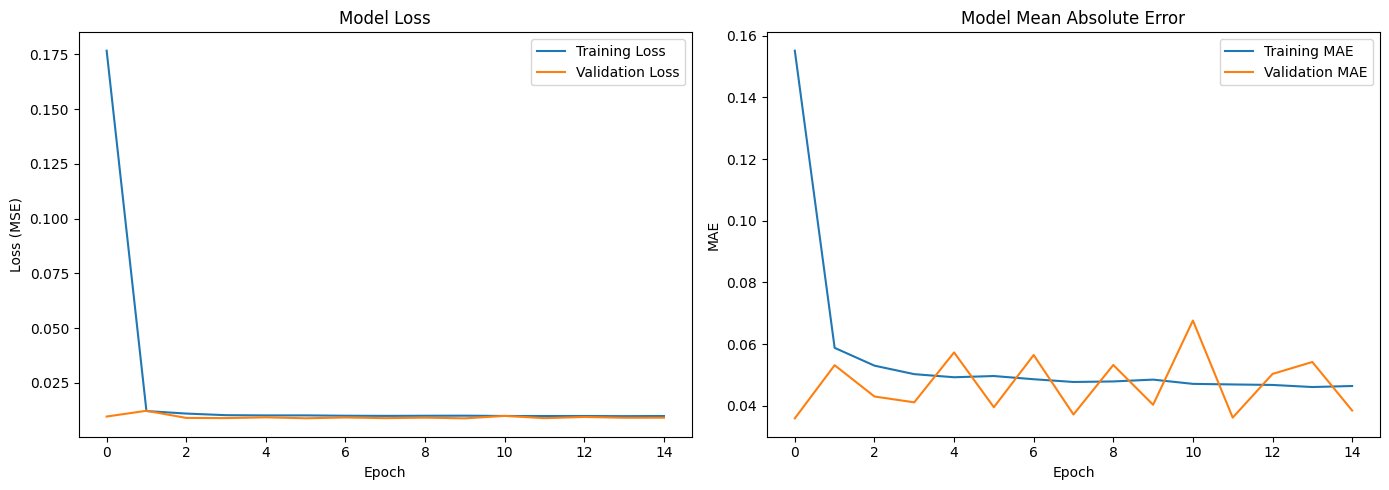

In [43]:
# Plotting the training and validation loss and MAE
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend(loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [44]:
# Evaluate the model on the test dataset
test_results = model.evaluate(test_dataset, return_dict=True)
#print(f"Test Loss (MSE): {test_results['loss']}, Test MAE: {test_results['mean_absolute_error']}")

# model.predict() !!! (not model.evaluate)

132/132 [==============================] - 32s 239ms/step - loss: 0.0095 - mean_absolute_error: 0.0413


In [45]:
test_predictions = model.predict(test_dataset)

132/132 [==============================] - 33s 236ms/step


In [47]:
#print(test_predictions.shape)
#flattened_predictions = test_predictions.reshape(-1)
#print(flattened_predictions.shape)
#print(flattened_predictions)
#de_scaled_predictions = de_scale(flattened_predictions.reshape(-1, 1), 'blr_mod_lvl')
#print(de_scaled_predictions)

# we get the predictions that correspond to the target_test

#print(target_test.shape)
#flattened_target = target_test.reshape(-1)
#print(flattened_target)
#de_scaled_target = de_scale(flattened_target.reshape(-1, 1), 'blr_mod_lvl')
#print(de_scaled_target)

In [48]:
def get_test_values(test_values):
  flattened_test_values = test_values.reshape(-1)
  de_scaled_test_values = de_scale(flattened_test_values.reshape(-1, 1), 'blr_mod_lvl')
  final_test_values = de_scaled_test_values.reshape(-1)
  return final_test_values

In [49]:
# function which randomly selects one day from the original prediction results
def get_random_day(predictions, target):
  random_day_index = random.randint(0, predictions.shape[0] - 1)
  selected_day_prediction = predictions[random_day_index]
  selected_day_target = target[random_day_index]
  selected_day_prediction_final = get_test_values(selected_day_prediction)
  selected_day_target_final = get_test_values(selected_day_target)
  return selected_day_prediction_final, selected_day_target_final

In [50]:
random_day_prediction, random_day_target = get_random_day(test_predictions, target_test)
print("Random Day Prediction:", random_day_prediction)
print("Random Day Target:", random_day_target)

Random Day Prediction: [1.989726  1.9786506 1.978123  ... 2.0164082 2.0000389 1.9886976]
Random Day Target: [0.         0.         0.         ... 0.00130608 0.00087072 0.00058048]


In [51]:
# function that gives us the error metrics for given pair target, prediction
def get_error_metrics(target, prediction):
  # error values
  error = [t - p for t, p in zip(target, prediction)]
  AE = [abs(e) for e in error] # Absolute Error
  SE = [e ** 2 for e in error] # Squared Error
  APE = [abs((t - p) / t) for t, p in zip(target, prediction)] # Absolute Percentage Error

  # error metrics
  # Mean Absolute Error, gives magnitude of errors without caring for direction
  MAE = np.mean(AE)
  # Mean Squared Error, gives higher weight for larger errors
  MSE = np.mean(SE)
  # Root Mean Squared Error,  it is in the same units as the target variable
  RMSE = np.sqrt(MSE)
  # Mean Absolute Percentage Error, provides a perspective on the size of the error relative to the target values (given as percentage %)
  MAPE = np.mean(APE) * 100
  # R-Squared, statistical measure that represents the proportion of the variance for the target variable that's explained by the model
  # provides an indication of the goodness of fit
  mean_target = np.mean(target)
  diff = [t - mean_target for t in target]
  denominator = [d ** 2 for d in diff]
  R2 = 1 - (sum(SE) / sum(denominator))

  # minimum and maximum errors
  minimum_error = np.min(error)
  maximum_error = np.max(error)

  errors = pd.DataFrame({
      'blr_mod_lvl': target,
      'prediction': prediction,
      'error': error,
      'AE': AE,
      'SE': SE,
      'APE': APE
  })

  error_metrics = {
      'MAE': MAE,
      'MSE': MSE,
      'RMSE': RMSE,
      'MAPE': MAPE,
      'R2': R2,
      'min_error': minimum_error,
      'max_error': maximum_error
  }

  return errors, error_metrics


In [52]:
target = get_test_values(target_test)
prediction = get_test_values(test_predictions)

errors, error_metrics = get_error_metrics(target, prediction)

print("\n Table with errors")
print(errors)
print("\n Error metrics")
print(error_metrics)

<ipython-input-51-2779c559e665>:7: RuntimeWarning: divide by zero encountered in scalar divide
  APE = [abs((t - p) / t) for t, p in zip(target, prediction)] # Absolute Percentage Error
<ipython-input-51-2779c559e665>:7: RuntimeWarning: overflow encountered in scalar divide
  APE = [abs((t - p) / t) for t, p in zip(target, prediction)] # Absolute Percentage Error
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)



 Table with errors
          blr_mod_lvl  prediction     error        AE        SE           APE
0        0.000000e+00   -0.096794  0.096794  0.096794  0.009369           inf
1        0.000000e+00   -0.103110  0.103110  0.103110  0.010632           inf
2        0.000000e+00   -0.097540  0.097540  0.097540  0.009514           inf
3        0.000000e+00   -0.086699  0.086699  0.086699  0.007517           inf
4        0.000000e+00   -0.083593  0.083593  0.083593  0.006988           inf
...               ...         ...       ...       ...       ...           ...
1511995  1.382107e-06    0.404723 -0.404722  0.404722  0.163800  2.928293e+05
1511996  9.214050e-07    0.423284 -0.423283  0.423283  0.179168  4.593886e+05
1511997  6.142700e-07    0.428451 -0.428450  0.428450  0.183570  6.974952e+05
1511998  4.095133e-07    0.411536 -0.411536  0.411536  0.169362  1.004939e+06
1511999  2.730089e-07    0.382566 -0.382566  0.382566  0.146356  1.401294e+06

[1512000 rows x 6 columns]

 Error metrics


In [54]:
# Now the errors, error metrics for the random day
errors_day, error_metrics_day = get_error_metrics(random_day_target, random_day_prediction)

print("\n Table with errors for random day")
print(errors_day)
print("\n Error metrics for random day")
print(error_metrics_day)


 Table with errors for random day
      blr_mod_lvl  prediction     error        AE        SE          APE
0        0.000000    1.989726 -1.989726  1.989726  3.959009          inf
1        0.000000    1.978651 -1.978651  1.978651  3.915058          inf
2        0.000000    1.978123 -1.978123  1.978123  3.912970          inf
3        0.000000    1.989286 -1.989286  1.989286  3.957257          inf
4        0.000000    2.020539 -2.020539  2.020539  4.082577          inf
...           ...         ...       ...       ...       ...          ...
1435     0.002939    2.001720 -1.998781  1.998781  3.995126   680.162284
1436     0.001959    2.013955 -2.011996  2.011996  4.048126  1026.988534
1437     0.001306    2.016408 -2.015102  2.015102  4.060637  1542.861372
1438     0.000871    2.000039 -1.999168  1.999168  3.996673  2295.992296
1439     0.000580    1.988698 -1.988117  1.988117  3.952610  3424.950812

[1440 rows x 6 columns]

 Error metrics for random day
{'MAE': 2.550290021008026, 'MSE':

<ipython-input-51-2779c559e665>:7: RuntimeWarning: divide by zero encountered in scalar divide
  APE = [abs((t - p) / t) for t, p in zip(target, prediction)] # Absolute Percentage Error


In [55]:
# get plots with the error metrics
